# Big Data in Finance: Part II <BR><BR> Lecture Notes 10: Merge CRSP and Compustat 
   
**Instructor** <BR>
Lira Mota, lmota20@gsb.columbia.edu
    
**TA's:** <BR>
Meha Sadasivam, MSadasivam21@gsb.columbia.edu <BR>
Daheng Yang, dyang22@gsb.columbia.edu

**Objective:** <BR>
    
Create a final data set called "stock_annual" that has both crsp (permno/permco) and compustat (gvkey) identifiers.

## Query CRSP/Compustat merged table (annual or quarterly).

1. Output table is CRSP-centric with permno-datadate being the primary key.
2. Fiscal period end date must be within link date range.
3. WRDS SAS code can be found [here](https://wrds-web.wharton.upenn.edu/wrds/support/Data/_003Sample%20Programs/CRSP/index.cfm?).

## Set Up

In [1]:
#%% Packages 
import wrds
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time
from time import strptime, strftime

# Setups
pd.set_option("display.max_rows", 100) # max number or rows to be displayed 
%matplotlib inline 
plt.rcParams['figure.figsize'] = [10, 6]

In [2]:
db = wrds.Connection(wrds_username='lmota')  # make sure to configure wrds connector before hand.

Loading library list...
Done


In [3]:
# Load Compustat and CRSP data. Data downloaded in lecture notes 2 and 3.
compa = pd.read_pickle('/Users/liramertens/Dropbox/Columbia/BigData/class2021/lecture_outputs/compa_annual.pkl')
crspm = pd.read_pickle('/Users/liramertens/Dropbox/Columbia/BigData/class2021/lecture_outputs/crsp_montly.pkl')

## What is the difficulty with merging CRSP and Compustat?

### Possibility: CUSIP

A CUSIP is a nine-digit numeric (e.g. 037833100 for Apple) or nine-character alphanumeric (e.g. 38259P508 for Google) code that identifies a North American financial security for the purposes of facilitating clearing and settlement of trades. The CUSIP was adopted as an American National Standard under Accredited Standards X9.6. The acronym, pronounced as "kyoo-sip," derives from Committee on Uniform Security Identification Procedures.

The CUSIP system is owned by the American Bankers Association and is operated by S&P Global Market Intelligence. The operating body, CUSIP Global Services (CGS), also serves as the national numbering agency (NNA) for North America, and the CUSIP serves as the National Securities Identification Number (NSIN) for products issued from both the United States and Canada. 

Source: Wikipedia 


In [4]:
compa[['gvkey', 'datadate', 'fyear', 'conm', 'tic', 'cusip']][compa.tic=='T']

gvkey   datadate   fyear      conm tic      cusip
104563  009899 1984-12-31  1984.0  AT&T INC   T  00206R102
104566  009899 1985-12-31  1985.0  AT&T INC   T  00206R102
104573  009899 1986-12-31  1986.0  AT&T INC   T  00206R102
104574  009899 1987-12-31  1987.0  AT&T INC   T  00206R102
104575  009899 1988-12-31  1988.0  AT&T INC   T  00206R102
104576  009899 1989-12-31  1989.0  AT&T INC   T  00206R102
104577  009899 1990-12-31  1990.0  AT&T INC   T  00206R102
104578  009899 1991-12-31  1991.0  AT&T INC   T  00206R102
104579  009899 1992-12-31  1992.0  AT&T INC   T  00206R102
104580  009899 1993-12-31  1993.0  AT&T INC   T  00206R102
104581  009899 1994-12-31  1994.0  AT&T INC   T  00206R102
104582  009899 1995-12-31  1995.0  AT&T INC   T  00206R102
104583  009899 1996-12-31  1996.0  AT&T INC   T  00206R102
104584  009899 1997-12-31  1997.0  AT&T INC   T  00206R102
104585  009899 1998-12-31  1998.0  AT&T INC   T  00206R102
104586  009899 1999-12-31  1999.0  AT&T INC   T  00206R102
104587  009899 2000-12-31  2000.0  AT&T INC   T  00206R102
104588  009899 2001-12-31  2001.0  AT&T INC   T  00206R102
104589  009899 2002-12-31  2002.0  AT&T INC   T  00206R102
104590  009899 2003-12-31  2003.0  AT&T INC   T  00206R102
104591  009899 2004-12-31  2004.0  AT&T INC   T  00206R102
104592  009899 2005-12-31  2005.0  AT&T INC   T  00206R102
104594  009899 2006-12-31  2006.0  AT&T INC   T  00206R102
104595  009899 2007-12-31  2007.0  AT&T INC   T  00206R102
104597  009899 2008-12-31  2008.0  AT&T INC   T  00206R102
104598  009899 2009-12-31  2009.0  AT&T INC   T  00206R102
104600  009899 2010-12-31  2010.0  AT&T INC   T  00206R102
104601  009899 2011-12-31  2011.0  AT&T INC   T  00206R102
104602  009899 2012-12-31  2012.0  AT&T INC   T  00206R102
104603  009899 2013-12-31  2013.0  AT&T INC   T  00206R102
104604  009899 2014-12-31  2014.0  AT&T INC   T  00206R102
104605  009899 2015-12-31  2015.0  AT&T INC   T  00206R102
104606  009899 2016-12-31  2016.0  AT&T INC   T  00206R102
104607  009899 2017-12-31  2017.0  AT&T INC   T  00206R102
104608  009899 2018-12-31  2018.0  AT&T INC   T  00206R102
104609  009899 2019-12-31  2019.0  AT&T INC   T  00206R102
104610  009899 2020-12-31  2020.0  AT&T INC   T  00206R102

In [ ]:
crspm.columns

### Possibility: Names or Ticker 

In [5]:
crspm_t = crspm[['permno','permco','date', 'comnam', 'ticker', 'cusip', 'ncusip', 'retadj']][crspm.ticker=='T']

In [6]:
crspm_t.comnam.unique()

array(['AMERICAN TELEPHONE & TELEG CO', 'A T & T CORP', 'A T & T INC'],
      dtype=object)

In [7]:
crspm_t[crspm_t.comnam=='AMERICAN TELEPHONE & TELEG CO'].sort_values('date')

permno   permco       date                         comnam ticker  \
2853516   10401  20103.0 1980-02-29  AMERICAN TELEPHONE & TELEG CO      T   
2858568   10401  20103.0 1980-03-31  AMERICAN TELEPHONE & TELEG CO      T   
2863622   10401  20103.0 1980-04-30  AMERICAN TELEPHONE & TELEG CO      T   
2868681   10401  20103.0 1980-05-30  AMERICAN TELEPHONE & TELEG CO      T   
2873751   10401  20103.0 1980-06-30  AMERICAN TELEPHONE & TELEG CO      T   
...         ...      ...        ...                            ...    ...   
672847    10401  20103.0 1993-11-30  AMERICAN TELEPHONE & TELEG CO      T   
680782    10401  20103.0 1993-12-31  AMERICAN TELEPHONE & TELEG CO      T   
688770    10401  20103.0 1994-01-31  AMERICAN TELEPHONE & TELEG CO      T   
696803    10401  20103.0 1994-02-28  AMERICAN TELEPHONE & TELEG CO      T   
704909    10401  20103.0 1994-03-31  AMERICAN TELEPHONE & TELEG CO      T   

            cusip    ncusip    retadj  
2853516  00195750  03017710  0.002481  
2858568  00195750  03017710 -0.012690  
2863622  00195750  03017710  0.082262  
2868681  00195750  03017710  0.038005  
2873751  00195750  03017710 -0.016393  
...           ...       ...       ...  
672847   00195750  03017710 -0.050000  
680782   00195750  03017710 -0.032860  
688770   00195750  03017710  0.080952  
696803   00195750  03017710 -0.074890  
704909   00195750  03017710 -0.017524  

[170 rows x 8 columns]

In [8]:
crspm_t[crspm_t.comnam=='A T & T CORP'].sort_values('date')

permno   permco       date        comnam ticker     cusip    ncusip  \
713054    10401  20103.0 1994-04-29  A T & T CORP      T  00195750  00195710   
721275    10401  20103.0 1994-05-31  A T & T CORP      T  00195750  00195710   
729548    10401  20103.0 1994-06-30  A T & T CORP      T  00195750  00195710   
737845    10401  20103.0 1994-07-29  A T & T CORP      T  00195750  00195710   
746173    10401  20103.0 1994-08-31  A T & T CORP      T  00195750  00195710   
...         ...      ...        ...           ...    ...       ...       ...   
1824300   10401  20103.0 2005-07-29  A T & T CORP      T  00195750  00195750   
1831293   10401  20103.0 2005-08-31  A T & T CORP      T  00195750  00195750   
1838270   10401  20103.0 2005-09-30  A T & T CORP      T  00195750  00195750   
1845244   10401  20103.0 2005-10-31  A T & T CORP      T  00195750  00195750   
1852221   10401  20103.0 2005-11-30  A T & T CORP      T  00195750  00195750   

           retadj  
713054   0.000000  
721275   0.065854  
729548   0.001465  
737845   0.004598  
746173   0.000000  
...           ...  
1824300  0.052390  
1831293 -0.006061  
1838270  0.006098  
1845244  0.010985  
1852221  0.026009  

[140 rows x 8 columns]

In [9]:
crspm_t[crspm_t.comnam=='A T & T INC'].sort_values('date')

permno   permco       date       comnam ticker     cusip    ncusip  \
1860578   66093  21645.0 2005-12-30  A T & T INC      T  00206R10  00206R10   
1867533   66093  21645.0 2006-01-31  A T & T INC      T  00206R10  00206R10   
1874472   66093  21645.0 2006-02-28  A T & T INC      T  00206R10  00206R10   
1881403   66093  21645.0 2006-03-31  A T & T INC      T  00206R10  00206R10   
1888330   66093  21645.0 2006-04-28  A T & T INC      T  00206R10  00206R10   
...         ...      ...        ...          ...    ...       ...       ...   
3535464   66093  21645.0 2020-08-31  A T & T INC      T  00206R10  00206R10   
3543344   66093  21645.0 2020-09-30  A T & T INC      T  00206R10  00206R10   
3551289   66093  21645.0 2020-10-30  A T & T INC      T  00206R10  00206R10   
3559311   66093  21645.0 2020-11-30  A T & T INC      T  00206R10  00206R10   
3567306   66093  21645.0 2020-12-31  A T & T INC      T  00206R10  00206R10   

           retadj  
1860578 -0.016861  
1867533  0.073193  
1874472  0.063198  
1881403 -0.019935  
1888330 -0.018399  
...           ...  
3535464  0.007776  
3543344 -0.043610  
3551289 -0.034023  
3559311  0.064027  
3567306  0.000348  

[181 rows x 8 columns]

## Many Linking Tables

In [10]:
crsp_tables = db.list_tables(library="crsp") 
crsp_tables = pd.DataFrame({'tables':crsp_tables}) # Transform libs to a Pandas data frame to have a better display.
crsp_tables[crsp_tables.tables.str.contains('ccm')]

tables
19        ccm_lookup
20        ccm_qvards
21  ccmxpf_linktable
22    ccmxpf_lnkhist
23     ccmxpf_lnkrng
24    ccmxpf_lnkused

**CCMXPF_LNKHIST - Link History**


* CCMXPF_LNKHIST contains the historical and current links between GVKEY and LPERMNO/LPERMCO (previously known as NPERMN O/NPERMCO in old version CCM). 


* In addition, it includes the beginning and ending dates for links, the link types, and the primary issue marker, and liid codes (Compustat's secondary ID variable, IID).

[Source](https://wrds-www.wharton.upenn.edu/pages/support/research-wrds/research-guides/ccm-sas-datasets/)

## Many Linking Types

In [11]:
db.describe_table(library="crsp", table="ccmxpf_lnkhist")

Approximately 106217 rows in crsp.ccmxpf_lnkhist.


name  nullable              type
0      gvkey      True        VARCHAR(6)
1   linkprim      True        VARCHAR(1)
2       liid      True        VARCHAR(3)
3   linktype      True        VARCHAR(2)
4    lpermno      True  DOUBLE_PRECISION
5    lpermco      True  DOUBLE_PRECISION
6     linkdt      True              DATE
7  linkenddt      True              DATE

LINKPRIM: Primary issue marker for the link.

## Download Data

In [12]:
sql = '''SELECT gvkey, lpermno as permno, lpermco as permco, linktype, linkdt, linkenddt
         FROM crsp.ccmxpf_lnkhist
         WHERE linktype IN ('LC', 'LU', 'LS') 
      ''' 

link_table = db.raw_sql(sql, date_cols=['linkdt', 'linkenddt'])

## Understading Linking Table

In [13]:
# Example 
link_table[link_table.permco==21645]

gvkey   permno   permco linktype     linkdt linkenddt
8861  009899  66093.0  21645.0       LC 1984-02-16       NaT

In [14]:
# Example: LIBERTY MEDIA
link_table[link_table.permco==54311]

gvkey   permno   permco linktype     linkdt  linkenddt
14525  017010  13757.0  54311.0       LC 2013-01-14 2016-04-17
14526  017010  13758.0  54311.0       LC 2013-01-14 2016-04-15
14527  017010  14811.0  54311.0       LC 2014-07-24 2016-04-17
14528  017010  15998.0  54311.0       LC 2016-04-18 2017-12-31
14529  017010  15998.0  54311.0       LC 2018-01-01        NaT
14530  017010  15999.0  54311.0       LC 2016-04-16        NaT
14531  017010  16000.0  54311.0       LC 2016-04-18 2017-12-31
14532  017010  16000.0  54311.0       LC 2018-01-01        NaT
19026  027186  15996.0  54311.0       LC 2016-04-18 2017-12-31
19027  027186  15996.0  54311.0       LC 2018-01-01        NaT
19028  027186  15997.0  54311.0       LC 2016-04-18 2017-12-31
19029  027186  15997.0  54311.0       LC 2018-01-01        NaT
19030  027187  13757.0  54311.0       LS 2016-04-18 2017-12-31
19031  027187  13757.0  54311.0       LS 2018-01-01        NaT
19032  027187  14811.0  54311.0       LS 2016-04-18 2017-12-31
19033  027187  14811.0  54311.0       LS 2018-01-01        NaT

## Merge and Link

* Link type code. Each link is given a code describing the connection between the CRSP and Compustat data. 

* Values are:

    * LC – Link research complete. Standard connection between databases.
    * LU – Unresearched link to issue by CUSIP
    * LS – Link valid for this security only. Other CRSP PERMNOs with the same PERMCO will link to other GVKEYs.
    * LX – Link to a security that trades on another exchange system not included in CRSP data.
    * LD – Duplicate Link to a security. Another GVKEY/IID is a better link to that CRSP record.
    * LN – Primary link exists but Compustat does not have prices.
    * NR – No link available, confirmed by research
    * NU – No link available, not yet confirmed

In [15]:
link_table.linktype.value_counts()

LU    16201
LC    14413
LS     3644
Name: linktype, dtype: int64

In [16]:
compa.head()

gvkey   datadate                     conm    tic      cusip   fyear   fyr  \
0  001001 1980-12-31  A & M FOOD SERVICES INC  AMFD.  000165100  1980.0  12.0   
1  001001 1981-12-31  A & M FOOD SERVICES INC  AMFD.  000165100  1981.0  12.0   
2  001001 1982-12-31  A & M FOOD SERVICES INC  AMFD.  000165100  1982.0  12.0   
3  001001 1983-12-31  A & M FOOD SERVICES INC  AMFD.  000165100  1983.0  12.0   
4  001001 1984-12-31  A & M FOOD SERVICES INC  AMFD.  000165100  1984.0  12.0   

       at   capx    ceq  ...   ps     dt     be    cost     op      opbe  \
0     NaN    NaN    NaN  ...  NaN    NaN    NaN     NaN    NaN       NaN   
1     NaN    NaN    NaN  ...  NaN    NaN    NaN     NaN    NaN       NaN   
2     NaN    NaN    NaN  ...  NaN    NaN    NaN     NaN    NaN       NaN   
3  14.080  3.367  7.823  ...  0.0  0.000  7.823  23.508  1.887  0.241212   
4  16.267  5.496  8.962  ...  0.0  0.357  9.319  29.460  2.547  0.273313   

   at_lag       inv  fdiff  inv_capx  
0     NaN       NaN    NaN       NaN  
1     NaN       NaN    1.0       NaN  
2     NaN       NaN    1.0       NaN  
3     NaN       NaN    1.0       NaN  
4   14.08  0.155327    1.0  0.390341  

[5 rows x 50 columns]

In [17]:
df = pd.merge(compa, link_table, on=['gvkey'], how='inner') 

In [18]:
df

gvkey   datadate                     conm    tic      cusip   fyear  \
0       001001 1980-12-31  A & M FOOD SERVICES INC  AMFD.  000165100  1980.0   
1       001001 1981-12-31  A & M FOOD SERVICES INC  AMFD.  000165100  1981.0   
2       001001 1982-12-31  A & M FOOD SERVICES INC  AMFD.  000165100  1982.0   
3       001001 1983-12-31  A & M FOOD SERVICES INC  AMFD.  000165100  1983.0   
4       001001 1984-12-31  A & M FOOD SERVICES INC  AMFD.  000165100  1984.0   
...        ...        ...                      ...    ...        ...     ...   
422694  345980 2016-12-31         CONTEXTLOGIC INC   WISH  21077C107  2016.0   
422695  345980 2017-12-31         CONTEXTLOGIC INC   WISH  21077C107  2017.0   
422696  345980 2018-12-31         CONTEXTLOGIC INC   WISH  21077C107  2018.0   
422697  345980 2019-12-31         CONTEXTLOGIC INC   WISH  21077C107  2019.0   
422698  345980 2020-12-31         CONTEXTLOGIC INC   WISH  21077C107  2020.0   

         fyr        at    capx       ceq  ...      opbe   at_lag       inv  \
0       12.0       NaN     NaN       NaN  ...       NaN      NaN       NaN   
1       12.0       NaN     NaN       NaN  ...       NaN      NaN       NaN   
2       12.0       NaN     NaN       NaN  ...       NaN      NaN       NaN   
3       12.0    14.080   3.367     7.823  ...  0.241212      NaN       NaN   
4       12.0    16.267   5.496     8.962  ...  0.273313    14.08  0.155327   
...      ...       ...     ...       ...  ...       ...      ...       ...   
422694  12.0       NaN     NaN       NaN  ...       NaN      NaN       NaN   
422695  12.0       NaN     NaN       NaN  ...       NaN      NaN       NaN   
422696  12.0  1193.000  20.000 -1287.000  ...       NaN      NaN       NaN   
422697  12.0  1366.000  11.000 -1439.000  ...       NaN  1193.00  0.145013   
422698  12.0  2397.000   2.000  1027.000  ... -0.602726  1366.00  0.754758   

        fdiff  inv_capx   permno   permco  linktype     linkdt  linkenddt  
0         NaN       NaN  10015.0   6398.0        LU 1983-09-20 1986-07-31  
1         1.0       NaN  10015.0   6398.0        LU 1983-09-20 1986-07-31  
2         1.0       NaN  10015.0   6398.0        LU 1983-09-20 1986-07-31  
3         1.0       NaN  10015.0   6398.0        LU 1983-09-20 1986-07-31  
4         1.0  0.390341  10015.0   6398.0        LU 1983-09-20 1986-07-31  
...       ...       ...      ...      ...       ...        ...        ...  
422694    1.0       NaN  20333.0  57666.0        LC 2020-12-16        NaT  
422695    1.0       NaN  20333.0  57666.0        LC 2020-12-16        NaT  
422696    1.0       NaN  20333.0  57666.0        LC 2020-12-16        NaT  
422697    1.0  0.009220  20333.0  57666.0        LC 2020-12-16        NaT  
422698    1.0  0.001464  20333.0  57666.0        LC 2020-12-16        NaT  

[422699 rows x 55 columns]

In [19]:
df = df[(df.datadate >= df.linkdt) | (df.linkdt.isnull())]
df = df[(df.datadate <= df.linkenddt) | (df.linkenddt.isnull())]

In [20]:
df['permno'] = df['permno'].astype(int)
df['permco'] = df['permco'].astype(int)
df['datadate'] = pd.to_datetime(df['datadate'])

In [21]:
df.shape

(278305, 55)

In [22]:
compa.shape

(431612, 50)

In [23]:
df.duplicated(subset=['permco', 'datadate']).sum()

21066

In [26]:
 compa.groupby(['fyear']).gvkey.nunique().plot()

<AxesSubplot:xlabel='fyear'>

<AxesSubplot:xlabel='fyear'>

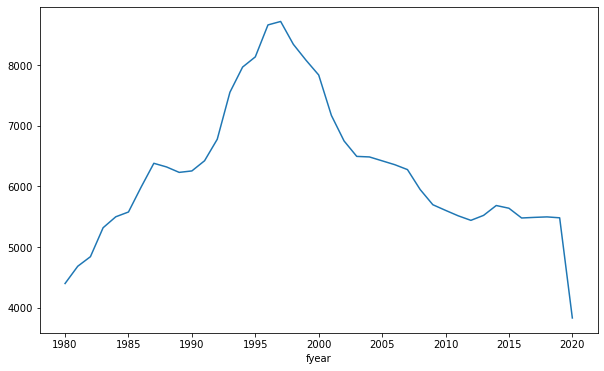

In [27]:
 df.groupby(['fyear']).permco.nunique().plot()

## Special Cases

### Many PERMCOs for One GVKEY

In [28]:
df.groupby('gvkey').permco.nunique().max()

4

In [30]:
df.groupby(['permno','datadate']).gvkey.nunique().max()

1

In [ ]:
df.loc[df.gvkey==df.groupby('gvkey').permco.nunique().idxmax(), ['datadate', 'permno', 'permco','gvkey', 'conm', 'at']]

### Many GVKEYs for one PERMCO

In [31]:
df[df['at'].notnull()].groupby('permco').gvkey.nunique().max()

5

In [32]:
pp = df[df['at'].notnull()].groupby('permco').gvkey.nunique().idxmax()

In [33]:
df.loc[df.permco==pp, ['datadate', 'permno', 'permco','gvkey', 'conm', 'at']].sort_values(['datadate'])

datadate  permno  permco   gvkey                        conm  \
353095 1994-12-31   81154    8243  118653       GENZYME TISSUE REPAIR   
353096 1995-12-31   81154    8243  118653       GENZYME TISSUE REPAIR   
161031 1996-12-31   10324    8243  012233                GENZYME CORP   
353097 1996-12-31   81154    8243  118653       GENZYME TISSUE REPAIR   
161032 1997-12-31   10324    8243  012233                GENZYME CORP   
353098 1997-12-31   81154    8243  118653       GENZYME TISSUE REPAIR   
352166 1998-12-31   86426    8243  117298  GENZYME MOLECULAR ONCOLOGY   
353099 1998-12-31   81154    8243  118653       GENZYME TISSUE REPAIR   
161033 1998-12-31   10324    8243  012233                GENZYME CORP   
353100 1999-12-31   81154    8243  118653       GENZYME TISSUE REPAIR   
161034 1999-12-31   10324    8243  012233                GENZYME CORP   
352167 1999-12-31   86426    8243  117298  GENZYME MOLECULAR ONCOLOGY   
355645 1999-12-31   86970    8243  121742   GENZYME SURGICAL PRODUCTS   
352168 2000-12-31   86426    8243  117298  GENZYME MOLECULAR ONCOLOGY   
370231 2000-12-31   88838    8243  143176          GENZYME BIOSURGERY   
161035 2000-12-31   10324    8243  012233                GENZYME CORP   
161036 2001-12-31   10324    8243  012233                GENZYME CORP   
370232 2001-12-31   88838    8243  143176          GENZYME BIOSURGERY   
352169 2001-12-31   86426    8243  117298  GENZYME MOLECULAR ONCOLOGY   
370233 2002-12-31   88838    8243  143176          GENZYME BIOSURGERY   
161037 2002-12-31   10324    8243  012233                GENZYME CORP   
352170 2002-12-31   86426    8243  117298  GENZYME MOLECULAR ONCOLOGY   
161038 2003-12-31   10324    8243  012233                GENZYME CORP   
161039 2004-12-31   10324    8243  012233                GENZYME CORP   
161040 2005-12-31   10324    8243  012233                GENZYME CORP   
161041 2006-12-31   10324    8243  012233                GENZYME CORP   
161042 2007-12-31   10324    8243  012233                GENZYME CORP   
161043 2008-12-31   10324    8243  012233                GENZYME CORP   
161044 2009-12-31   10324    8243  012233                GENZYME CORP   
161045 2010-12-31   10324    8243  012233                GENZYME CORP   

               at  
353095        NaN  
353096        NaN  
161031   1229.519  
353097     42.593  
161032   1203.056  
353098     56.818  
352166     35.952  
353099     18.954  
161033   1646.307  
353100     19.648  
161034   1399.583  
352167      9.692  
355645    370.924  
352168     30.752  
370231    811.600  
161035   2499.053  
161036   3225.254  
370232    704.671  
352169     42.419  
370233    560.792  
161037   3555.801  
352170     13.981  
161038   5004.528  
161039   6069.421  
161040   6878.865  
161041   7191.188  
161042   8301.741  
161043   8671.276  
161044  10060.724  
161045  10913.854

### Many GVKEYs for one PERMCO for the Same Date

In [34]:
df[df['at'].notnull()].groupby(['permco','datadate']).gvkey.nunique().max()

4

In [35]:
pp = df[df['at'].notnull()].groupby(['permco','datadate']).gvkey.nunique().idxmax()
pp

(8243, Timestamp('1999-12-31 00:00:00'))

In [36]:
df.loc[df.permco==8243, ['datadate', 'permno', 'permco','gvkey', 'conm', 'at']].sort_values(['datadate'])

datadate  permno  permco   gvkey                        conm  \
353095 1994-12-31   81154    8243  118653       GENZYME TISSUE REPAIR   
353096 1995-12-31   81154    8243  118653       GENZYME TISSUE REPAIR   
161031 1996-12-31   10324    8243  012233                GENZYME CORP   
353097 1996-12-31   81154    8243  118653       GENZYME TISSUE REPAIR   
161032 1997-12-31   10324    8243  012233                GENZYME CORP   
353098 1997-12-31   81154    8243  118653       GENZYME TISSUE REPAIR   
352166 1998-12-31   86426    8243  117298  GENZYME MOLECULAR ONCOLOGY   
353099 1998-12-31   81154    8243  118653       GENZYME TISSUE REPAIR   
161033 1998-12-31   10324    8243  012233                GENZYME CORP   
353100 1999-12-31   81154    8243  118653       GENZYME TISSUE REPAIR   
161034 1999-12-31   10324    8243  012233                GENZYME CORP   
352167 1999-12-31   86426    8243  117298  GENZYME MOLECULAR ONCOLOGY   
355645 1999-12-31   86970    8243  121742   GENZYME SURGICAL PRODUCTS   
352168 2000-12-31   86426    8243  117298  GENZYME MOLECULAR ONCOLOGY   
370231 2000-12-31   88838    8243  143176          GENZYME BIOSURGERY   
161035 2000-12-31   10324    8243  012233                GENZYME CORP   
161036 2001-12-31   10324    8243  012233                GENZYME CORP   
370232 2001-12-31   88838    8243  143176          GENZYME BIOSURGERY   
352169 2001-12-31   86426    8243  117298  GENZYME MOLECULAR ONCOLOGY   
370233 2002-12-31   88838    8243  143176          GENZYME BIOSURGERY   
161037 2002-12-31   10324    8243  012233                GENZYME CORP   
352170 2002-12-31   86426    8243  117298  GENZYME MOLECULAR ONCOLOGY   
161038 2003-12-31   10324    8243  012233                GENZYME CORP   
161039 2004-12-31   10324    8243  012233                GENZYME CORP   
161040 2005-12-31   10324    8243  012233                GENZYME CORP   
161041 2006-12-31   10324    8243  012233                GENZYME CORP   
161042 2007-12-31   10324    8243  012233                GENZYME CORP   
161043 2008-12-31   10324    8243  012233                GENZYME CORP   
161044 2009-12-31   10324    8243  012233                GENZYME CORP   
161045 2010-12-31   10324    8243  012233                GENZYME CORP   

               at  
353095        NaN  
353096        NaN  
161031   1229.519  
353097     42.593  
161032   1203.056  
353098     56.818  
352166     35.952  
353099     18.954  
161033   1646.307  
353100     19.648  
161034   1399.583  
352167      9.692  
355645    370.924  
352168     30.752  
370231    811.600  
161035   2499.053  
161036   3225.254  
370232    704.671  
352169     42.419  
370233    560.792  
161037   3555.801  
352170     13.981  
161038   5004.528  
161039   6069.421  
161040   6878.865  
161041   7191.188  
161042   8301.741  
161043   8671.276  
161044  10060.724  
161045  10913.854

In [37]:
df.loc[df.permco==54311, ['datadate', 'permno', 'permco','gvkey', 'conm', 'at']].sort_values(['datadate'])

datadate  permno  permco   gvkey                          conm  \
214732 2013-12-31   13757   54311  017010  LIBERTY MEDIA SIRIUSXM GROUP   
214733 2013-12-31   13758   54311  017010  LIBERTY MEDIA SIRIUSXM GROUP   
214740 2014-12-31   13757   54311  017010  LIBERTY MEDIA SIRIUSXM GROUP   
214741 2014-12-31   13758   54311  017010  LIBERTY MEDIA SIRIUSXM GROUP   
214742 2014-12-31   14811   54311  017010  LIBERTY MEDIA SIRIUSXM GROUP   
214748 2015-12-31   13757   54311  017010  LIBERTY MEDIA SIRIUSXM GROUP   
214749 2015-12-31   13758   54311  017010  LIBERTY MEDIA SIRIUSXM GROUP   
214750 2015-12-31   14811   54311  017010  LIBERTY MEDIA SIRIUSXM GROUP   
268141 2016-12-31   15997   54311  027186    LIBERTY MEDIA BRAVES GROUP   
268167 2016-12-31   13757   54311  027187     LIBERTY MEDIA FORMULA ONE   
214759 2016-12-31   15998   54311  017010  LIBERTY MEDIA SIRIUSXM GROUP   
214761 2016-12-31   15999   54311  017010  LIBERTY MEDIA SIRIUSXM GROUP   
268139 2016-12-31   15996   54311  027186    LIBERTY MEDIA BRAVES GROUP   
214762 2016-12-31   16000   54311  017010  LIBERTY MEDIA SIRIUSXM GROUP   
268169 2016-12-31   14811   54311  027187     LIBERTY MEDIA FORMULA ONE   
268173 2017-12-31   14811   54311  027187     LIBERTY MEDIA FORMULA ONE   
268145 2017-12-31   15997   54311  027186    LIBERTY MEDIA BRAVES GROUP   
268143 2017-12-31   15996   54311  027186    LIBERTY MEDIA BRAVES GROUP   
268171 2017-12-31   13757   54311  027187     LIBERTY MEDIA FORMULA ONE   
214767 2017-12-31   15998   54311  017010  LIBERTY MEDIA SIRIUSXM GROUP   
214769 2017-12-31   15999   54311  017010  LIBERTY MEDIA SIRIUSXM GROUP   
214770 2017-12-31   16000   54311  017010  LIBERTY MEDIA SIRIUSXM GROUP   
268148 2018-12-31   15996   54311  027186    LIBERTY MEDIA BRAVES GROUP   
268178 2018-12-31   14811   54311  027187     LIBERTY MEDIA FORMULA ONE   
214779 2018-12-31   16000   54311  017010  LIBERTY MEDIA SIRIUSXM GROUP   
214777 2018-12-31   15999   54311  017010  LIBERTY MEDIA SIRIUSXM GROUP   
214776 2018-12-31   15998   54311  017010  LIBERTY MEDIA SIRIUSXM GROUP   
268176 2018-12-31   13757   54311  027187     LIBERTY MEDIA FORMULA ONE   
268150 2018-12-31   15997   54311  027186    LIBERTY MEDIA BRAVES GROUP   
268154 2019-12-31   15997   54311  027186    LIBERTY MEDIA BRAVES GROUP   
214787 2019-12-31   16000   54311  017010  LIBERTY MEDIA SIRIUSXM GROUP   
214785 2019-12-31   15999   54311  017010  LIBERTY MEDIA SIRIUSXM GROUP   
268180 2019-12-31   13757   54311  027187     LIBERTY MEDIA FORMULA ONE   
268182 2019-12-31   14811   54311  027187     LIBERTY MEDIA FORMULA ONE   
268152 2019-12-31   15996   54311  027186    LIBERTY MEDIA BRAVES GROUP   
214784 2019-12-31   15998   54311  017010  LIBERTY MEDIA SIRIUSXM GROUP   
214793 2020-12-31   15999   54311  017010  LIBERTY MEDIA SIRIUSXM GROUP   
268156 2020-12-31   15996   54311  027186    LIBERTY MEDIA BRAVES GROUP   
214795 2020-12-31   16000   54311  017010  LIBERTY MEDIA SIRIUSXM GROUP   
268184 2020-12-31   13757   54311  027187     LIBERTY MEDIA FORMULA ONE   
214792 2020-12-31   15998   54311  017010  LIBERTY MEDIA SIRIUSXM GROUP   
268158 2020-12-31   15997   54311  027186    LIBERTY MEDIA BRAVES GROUP   
268186 2020-12-31   14811   54311  027187     LIBERTY MEDIA FORMULA ONE   

             at  
214732  34542.0  
214733  34542.0  
214740  31207.0  
214741  31207.0  
214742  31207.0  
214748  29798.0  
214749  29798.0  
214750  29798.0  
268141   1548.0  
268167   2995.0  
214759  27051.0  
214761  27051.0  
268139   1548.0  
214762  27051.0  
268169   2995.0  
268173  11802.0  
268145   1866.0  
268143   1866.0  
268171  11802.0  
214767  28530.0  
214769  28530.0  
214770  28530.0  
268148   1805.0  
268178  10957.0  
214779  28292.0  
214777  28292.0  
214776  28292.0  
268176  10957.0  
268150   1805.0  
268154   1593.0  
214787  31421.0  
214785  31421.0  
268180  11505.0  
268182  11505.0  
268152   1593.0  
214784  31421.0  
214793  32081.0  
268156   1571.0  
214795